In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def obj_func(m):
    u, s, vh = np.linalg.svd(m)

    return np.sum(s[1:])

epsilon = 1

def comp_grad(m, boolMask, obj_func, n, epsilon=epsilon):
    """ Computes gradient that maximizes the objective function """

    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))

    return grad

def comp_hessian(m, boolMask, of, n, epsilon=epsilon):
    """ Computes hessian (only diagonal) """
    vector = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                vector.append(m[i,j])

    q = len(vector)
    hessian = np.zeros([q, q])

    # fill in the diagonal first
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:

                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian[count,count] = (of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2

                count = count + 1
                
    # now fill in off-diagonals
    count1 = 0
    for i1 in range(n):
        for j1 in range(n):
            if boolMask[i1,j1]: # found one
                diff1 = np.zeros([n,n])
                diff1[i1,j1] = epsilon

                count2 = 0
                for i2 in range(n):
                    for j2 in range(n):
                        if boolMask[i2,j2]: # found another one
                            diff2 = np.zeros([n,n])
                            diff2[i2,j2] = epsilon

                            if count1 != count2: # doing only off-diagonal ones
                                hessian[count1,count2] = (of(m + diff1 + diff2) + of(m - diff1 - diff2)
                                                         - of(m + diff1 - diff2) - of(m - diff1 + diff2))/(2*epsilon)**2

                            count2 = count2 + 1

                count1 = count1 + 1

    return hessian

In [3]:
n = 10
p = 0.5
rank = 1

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
original = np.dot(U, V.T)
mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))

In [4]:
current_point = np.copy(original)

zeros = np.zeros([n,n])
current_point[boolMask] = zeros[boolMask]

print("step, nuc norm, frob distance, hessian cond")#, grad mean, grad std, grad min, grad max")
nuc_norms = []
frob_norms = []
conds = []

for step in range(10000):

    hessian = comp_hessian(current_point, boolMask, obj_func, n)
    grad = comp_grad(current_point, boolMask, obj_func, n)

    #descent = -np.dot(np.linalg.inv(hessian), grad)
    descent = -np.array(grad)
    
    descent_matrix = np.zeros([n,n])
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                descent_matrix[i,j] = descent[count]
                count = count + 1
    
    current_point = current_point + 0.1*descent_matrix
    
    nuc_norms.append(np.linalg.norm(current_point,'nuc'))
    frob_norms.append(np.linalg.norm(current_point-original,'fro'))
    conds.append(np.linalg.cond(hessian))
    
    if step % 20 == 0:
        print(step, np.linalg.norm(current_point,'nuc'), np.linalg.norm(current_point-original,'fro'),
              np.linalg.cond(hessian))#, np.mean(np.abs(grad)),
             # np.std(np.abs(grad)), np.min(np.abs(grad)), np.max(np.abs(grad)))
    

step, nuc norm, frob distance, hessian cond
0 8.213680437861013 3.5501656150072254 532.170903291312
20 7.023829939678159 2.4159173754168397 6.082482935024602
40 6.5286232551098475 1.6599965203222014 3.9874875471446654
60 6.338333179737752 1.1971952472400402 2.9259414485144313
80 6.275987192870397 0.9408464639684805 2.5842109045964543
100 6.272415213327386 0.7696976634186089 2.4345502303205544
120 6.274733827315875 0.636580197217209 2.3131354346664685
140 6.291434891802409 0.5290999241815958 2.2213500749477837
160 6.31374485968753 0.44101800489973375 2.1660041643282866
180 6.330369393909753 0.36904437703306403 2.1200401631627055
200 6.342150619104563 0.311979110514584 2.091434574889845
220 6.351562914789838 0.27002656869988895 2.097848457328045
240 6.363077322293875 0.24394976279370734 2.113612005949998
260 6.375544857187798 0.2334985775017078 2.1254076200119925
280 6.393169810300473 0.23677905960899534 2.1288088876486144
300 6.414879933391433 0.2510270185580003 2.1409585817066543
320 6

KeyboardInterrupt: 

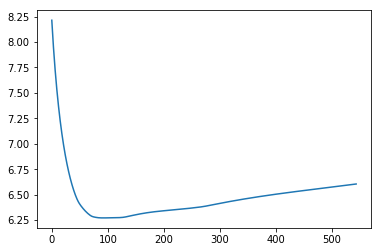

In [5]:
plt.plot(nuc_norms)

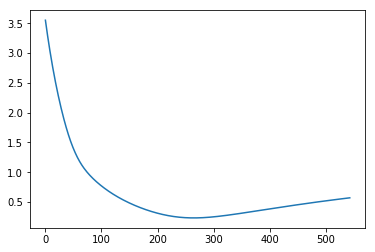

In [6]:
plt.plot(frob_norms)

So things seem to break. Is it because epsilon is off at this stage?

In [11]:
epsilons = []
conds = []

for p in range(30):

    epsilon = 10**(-p)
    hessian = comp_hessian(current_point, boolMask, obj_func, n, epsilon)
    cond = np.linalg.cond(hessian)
    print(epsilon, cond)
    epsilons.append(epsilon)
    conds.append(cond)

1 2.42648805306135
0.1 19.039357185684675
0.01 40096.85185120677
0.001 276780.14104606915
0.0001 1442878.3479704105
1e-05 1019723.9780562109
1e-06 2011765.4783497783
1e-07 1077468.7905798627
1e-08 2011.0019408955902
1e-09 140.14313695349574
1e-10 39.02671964877899
1e-11 78.14018817608311
1e-12 67.90749165776204
1e-13 61.85559307582897
1e-14 719.7232259453743
1e-15 211.09254045423572
1e-16 5.955170051771914e+16
1e-17 inf
1e-18 inf
1e-19 inf
1e-20 inf
1e-21 inf
1e-22 inf
1e-23 inf
1e-24 inf
1e-25 inf
1e-26 inf
1e-27 inf
1e-28 inf
1e-29 inf


In [12]:
epsilons = []
conds = []

for p in range(30):

    epsilon = 1+p#10**(-p)
    hessian = comp_hessian(current_point, boolMask, obj_func, n, epsilon)
    cond = np.linalg.cond(hessian)
    print(epsilon, cond)
    epsilons.append(epsilon)
    conds.append(cond)

1 2.42648805306135
2 2.24108940163063
3 2.33343592014357
4 2.558085964090114
5 2.5488584495898507
6 2.434837198150068
7 2.2476744630092282
8 2.0779374743994237
9 1.9705446369282533
10 1.904406030625881
11 1.863495991994038
12 1.838402587247122
13 1.8230616953502294
14 1.813500574648978
15 1.8073366300231988
16 1.803230162289867
17 1.8004133429075209
18 1.7984314131637098
19 1.7970022014632476
20 1.7959475030340735
21 1.7951520298627015
22 1.7945393738397724
23 1.794057819560918
24 1.7936717178863453
25 1.7933560953557832
26 1.7930932037596456
27 1.7928702648339943
28 1.7926779685818617
29 1.7925094568772466
30 1.7923596253393563


Epsilon need to be some small number, but there is also some freedom to choose it so that the hessian is well-conditioned, from above:

1e-09 140.14313695349574

1e-10 39.02671964877899

1e-11 78.14018817608311

1e-12 67.90749165776204

1e-13 61.85559307582897

So, epsilons in the rage 1e-13 to 1e-9 work best